<a href="https://colab.research.google.com/github/UOS-COMP6252/public/blob/main/lecture5/conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution Networks

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as vision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import SGD,Adam

## Convolution and Max pooling examples in PyTorch

Note the following:

1. The **depth** of every filter **must** be equal to the number of input channels
1. A filter has different values for each input channel
1. The convolution operation sums the contributions from all the channels
1. Therefore the number of output channels is exactly equal to the number of filters

In [3]:
# a and b have 1 channel and dimension 4x4
a=torch.ones([2,3,3])
a[1,:,:]=3.
b=torch.ones([2,3,3])
# stack a and b together to create a sample of size 2
x=torch.stack([a,b])

print("X's size={}".format(list(x.size())))
print("a[0]=\n{}".format(a[0].numpy()))
print("a[1]=\n{}".format(a[1].numpy()))

X's size=[2, 2, 3, 3]
a[0]=
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
a[1]=
[[3. 3. 3.]
 [3. 3. 3.]
 [3. 3. 3.]]


Recall dimensions used in the convolution operation.
Let $s,i,j,f$ be the number of samples,output height index,output width index, and the filter index respectively. The convolution operation is defined as
\begin{align*}
O_{s,f,i,j}=b_f+ \sum_c\sum_{m,n}X_{s,c,i+m,j+n}*K_{f,c,m,n}
\end{align*}

- ```c``` depdens on the number of channels in the input.```a```, ```b```,```x```, have 2 channels 
- In this example we choose 3 filters, each with height and width of 2x2
- In Pytorch a convolution layer is created as follows

```nn.Conv2d(in_channels=2,out_channels=3,kernel_size=2,bias=False)```
- Note that we chose to omit the bias for simplicity

In [4]:
# the in_channels must be 2 to match # channels of a and b
l=nn.Conv2d(in_channels=2,out_channels=3,kernel_size=2,bias=False)
with torch.no_grad():
    # all values set to 1 except the second channel to 3 (for all filters)
    l.weight.fill_(1.)
    l.weight[:,1,:,:].fill_(3.)
p=l.parameters()
w=next(p)
s=w.size()
print("filter index={},channel={},height={},width={}".format(s[0],s[1],s[2],s[3]))

filter index=3,channel=2,height=2,width=2


In [5]:
d=l(x)
s=d.size()
print("output samples={},channels={},height={},width={}".format(s[0],s[1],s[2],s[3]))

output samples=2,channels=3,height=2,width=2


Consider the output for the first sample (the convolution of ```a```). Since all the kernels are the same we inspect one output channel. Therefore, we are considering the values in ```d[0,0,:,:]```.

```a``` has two input channels: the first has values all ones and the second all 3s.
The filter has values ones for the first channel and 3s for the second. Since the receptive field is 2x2 then the convolution would result in:
\begin{align*}
(1\times 1+1\times 1+1\times 1+1\times 1)+(3\times 3+3\times 3+3\times 3+3\times 3)\\
=40
\end{align*}

In [6]:
# convolution of a
#print(d[0,0,:,:].detach().numpy())
with torch.no_grad():
    print(d[0,0,:,:].numpy())

[[40. 40.]
 [40. 40.]]


The output of the second sample (the convolution of ```b```) is similar
\begin{align*}
(1\times 1+1\times 1+1\times 1+1\times 1)+(1\times 3+1\times 3+1\times 3+1\times 3)\\
=16
\end{align*}

In [7]:
# convolution of b
print(d[1,0,:,:].detach().numpy())

[[16. 16.]
 [16. 16.]]


### Max pooling

- Recall that max pooling with kernel size $h\times w$ and stride $s$ computes the maximum value of the input in the window $h\times w$.
- It then "slides" that window by $s$.
- Max pooling is performed in PyTorch using ```nn.MaxPool2d```
- Example:
- Input is a single channel with size 3x3
- By default the kernel is square so specifying 2 means 2x2
- By default the stride is the same as the kernel size


In [8]:
a=torch.tensor([[1,2,3],[4,5,6],[7,8,9]],dtype=torch.float32)
b=torch.tensor([[10,11,12],[13,14,15],[16,17,18]],dtype=torch.float32)
# stack a and b together to create a sample of size 2
x=torch.stack([a,b])

# By default a square kernel so 2 is the same as 2x2
# If the stride is not specified it defaults to kernel size
maxpool=nn.MaxPool2d(2)
y=maxpool(x)
print(y.numpy())

[[[ 5.]]

 [[14.]]]


- Notice how the above has a single value. 
- Because when a stride of 2 (the default) is applied, the kernel "overshoots" the input 
- Figure below represents the computation for "sample" ```a```
- Therefore only a single computation is done

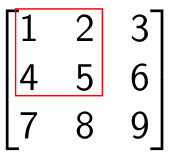

- What if we changed the stride to 1?
- The obtained values are easy to interpret by recalling the values of x

In [10]:
maxpool=nn.MaxPool2d(kernel_size=2,stride=1)# 1 stride 
y=maxpool(x)
print(y)

tensor([[[ 5.,  6.],
         [ 8.,  9.]],

        [[14., 15.],
         [17., 18.]]])


In [11]:
print(x)

tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.]],

        [[10., 11., 12.],
         [13., 14., 15.],
         [16., 17., 18.]]])


### Convolution Network for CIFAR10

In [12]:
# select the device 
#to ensure some reproducibility 
seed=9 
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

In [13]:
transform = transforms.ToTensor()
dataset_train=vision.datasets.CIFAR10(".",download=True,train=True,transform=transform)
dataset_test=vision.datasets.CIFAR10(".",download=True,train=False,transform=transform)
loader_train=DataLoader(dataset_train,batch_size=64,shuffle=True,num_workers=2)
loader_test=DataLoader(dataset_test,batch_size=512,shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [14]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # input is (*,3,32,32)
    self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)
    self.relu=nn.ReLU()
    # input is (*,32,30,30)
    self.conv2=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3)
    # input is (*,32,28,28)
    self.pool1=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,32,14,14)
    self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
    # input is (*,64,12,12)
    self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
    # input is (*,64,10,10)
    self.pool2=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,64,5,5)
    self.flatten=nn.Flatten()
    # input is (*,64x5x5)
    self.fc1=nn.Linear(in_features=5*5*64,out_features=128)
    self.fc2=nn.Linear(in_features=128,out_features=10)

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu(x)
    x=self.conv2(x)
    x=self.relu(x)
    x=self.pool1(x)
    
    x=self.conv3(x)
    x=self.relu(x)
    x=self.conv4(x)
    x=self.relu(x)
    x=self.pool2(x)
    
    x=self.flatten(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    return x
    

In [ ]:
def get_accuracy(dataloader,model,device):
  total=len(dataloader.dataset.data)
  correct=0
  for data in dataloader:
    imgs,labels=data
    imgs=imgs.to(device)
    labels=labels.to(device)
    outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
    _,predicted=torch.max(outputs.data,1)
    correct+=(predicted==labels).sum()
  

  return (correct/total).item()

In [ ]:
model=Net().to(device)
optimizer=Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

In [ ]:
import datetime
from torch.utils.tensorboard import SummaryWriter
# To display tensorboard inside the notebook
%load_ext tensorboard
current_time = str(datetime.datetime.now().timestamp())
log_dir = 'logs/tensorboard/' + current_time
writer=SummaryWriter(log_dir)

In [ ]:
epochs=20
from tqdm import tqdm
for epoch in range(epochs):
  loop=tqdm(loader_train)
  loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
  epoch_loss=0.
  for (imgs,labels) in loop:
    optimizer.zero_grad()
    imgs=imgs.to(device)
    labels=labels.to(device)
    outputs=model(imgs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss=0.9*epoch_loss+0.1*loss.item()
    loop.set_postfix(loss=epoch_loss)
  t_acc=get_accuracy(loader_train,model,device) 
  v_acc=get_accuracy(loader_test,model,device)
  writer.add_scalar("loss",epoch_loss,epoch)
  writer.add_scalars("acc",{'train':t_acc,'valid':v_acc},epoch)
writer.close()   

In [ ]:
%tensorboard --logdir logs/tensorboard

In [ ]:
try:
   from torchmetrics import ConfusionMatrix
except: 
    !pip install torchmetrics
    from torchmetrics import ConfusionMatrix

conmat=ConfusionMatrix(task='multiclass',num_classes=10)
conmat=conmat.to(device)

In [ ]:
total=0
correct=0
for data in loader_test:
  imgs,labels=data
  imgs=imgs.to(device)
  labels=labels.to(device)
  outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
  _,predicted=torch.max(outputs.data,1)
  correct+=(predicted==labels).sum()
  total+=labels.size()[0]
  conmat.update(predicted,labels)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")

- The rows are the actual images and the columns are the prediction (How can you check?)
- While the prediction accuracy is good albeit not impressive
- From the confusion matrix we find justifications for the inaccuracies
- For example
    - most of the incorrect classifications of automobiles were classified as trucks
    - most of the incorrect classifications of cats/dogs were classified as dogs/cats
    

### Using cpu
- It would be interesting to compare the performance of GPU vs CPU.
- Below is the same training loop using the CPU
- After that I show a snapshot of the training GPUvsCPU on my own desktop (NVIDIA RTX 3070)

In [ ]:
device=torch.device('cpu')
model=Net().to(device)
epochs=20
from tqdm import tqdm
for epoch in range(epochs):
  loop=tqdm(loader_train)
  loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
  epoch_loss=0.
  for (imgs,labels) in loop:
    optimizer.zero_grad()
    imgs=imgs.to(device)
    labels=labels.to(device)
    outputs=model(imgs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss=0.9*epoch_loss+0.1*loss.item()
    loop.set_postfix(loss=epoch_loss)

### GPU

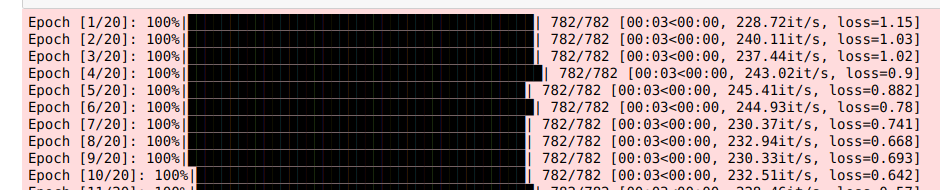

### CPU

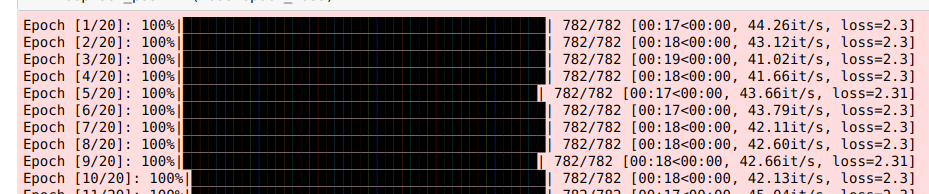
